# IFT 599 - TP2 : Clustering et Détection d'Anomalies

**Étudiants :**
* Ilyass Jenjare (JENI1801)
* Zakaria Meliane (MELZ3501)

**Contexte :**
Ce projet explore l'impact de la **malédiction de la dimensionnalité** sur les algorithmes d'apprentissage non supervisé. Nous analyserons des données génomiques (Clustering) et des signaux physiologiques (Anomalies).

In [1]:
import sys
sys.path.append(r"C:\Users\jenja\Desktop\Session automne 2025\Science_données\TP2 - IFT 599\anomaly_detection")
from preprocess import load_hiseq_data, preprocess_hiseq, apply_pca, apply_umap


#  Partie 1 : Clustering de Données Génomiques (Hi-Seq)

**Objectif :** Segmenter 5 types de tumeurs à partir de profils d'expression génique (RNA-Seq).

**Données :** 801 échantillons x 20 531 gènes.
**Défi :** La très haute dimension rend les distances euclidiennes peu significatives. Nous comparerons l'impact de la réduction de dimension linéaire (**ACP**) vs non-linéaire (**UMAP**).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from preprocess import load_hiseq_data, preprocess_hiseq, apply_pca, apply_umap
from models import get_kmeans_model, get_dbscan_model, get_spectral_model
from utils import run_clustering_multiple_seeds, plot_2d_embedding, split_ecg_data, compute_metrics
from preprocess import scan_fichier_npz


In [3]:
hiseq_path = r"C:\Users\jenja\Desktop\Session automne 2025\Science_données\TP2 - IFT 599\hiseq_data.csv"
hiseq_labels_path = r"C:\Users\jenja\Desktop\Session automne 2025\Science_données\TP2 - IFT 599\hiseq_labels.csv"

X_hiseq, y_hiseq = load_hiseq_data(hiseq_path, hiseq_labels_path)

print(X_hiseq.shape)
print(y_hiseq.value_counts())


(801, 20531)
Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


In [4]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_hiseq)
class_names = le.classes_
class_names


array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

## Prétraitement et Réduction de Dimension

1.  **Normalisation :** StandardScaler (Moyenne = 0, Écart-type = 1).
2.  **ACP (PCA) :** Projection linéaire sur les 100 composantes principales.
3.  **UMAP :** Projection non-linéaire (Manifold Learning) sur 100 composantes.

In [5]:
X_scaled, X_pca100, X_umap100 = preprocess_hiseq(X_hiseq)

print("Scaled:", X_scaled.shape)
print("PCA 100:", X_pca100.shape)
print("UMAP 100:", X_umap100.shape)


c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Scaled: (801, 20531)
PCA 100: (801, 100)
UMAP 100: (801, 100)


In [6]:
pca2 = apply_pca(X_scaled, Nb=2)

umap2 = apply_umap(X_scaled, Nb=2)


c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


##  Visualisation 2D : ACP vs UMAP

Nous projetons les données en 2D pour visualiser la séparabilité des classes (types de cancers).
* **ACP :** Cherche à préserver la variance globale.
* **UMAP :** Cherche à préserver la topologie locale.

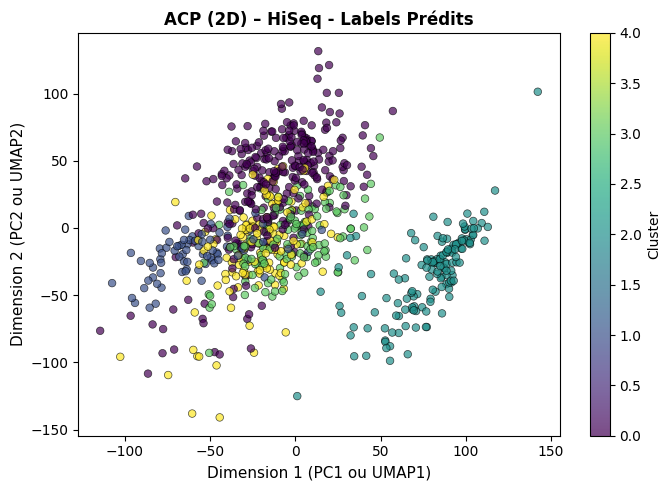

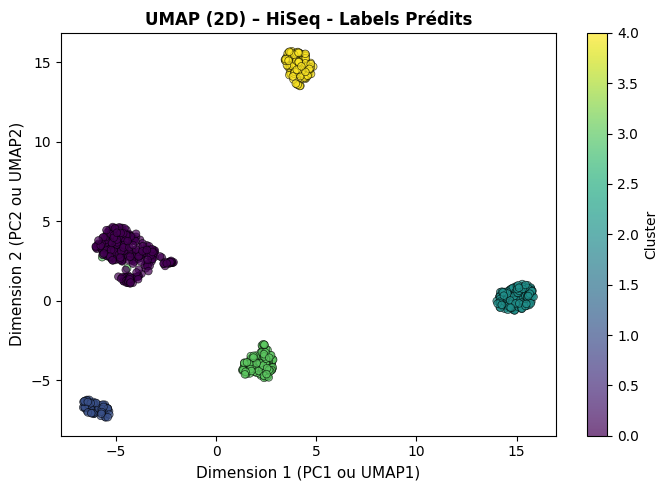

In [7]:
plot_2d_embedding(pca2, y_encoded, title="ACP (2D) – HiSeq")
plot_2d_embedding(umap2, y_encoded, title="UMAP (2D) – HiSeq")


# Partie Clustering

##  Comparaison des Algorithmes de Clustering

Nous exécutons **K-Means**, **DBSCAN** et **Spectral Clustering** sur les trois versions des données (Brutes, PCA, UMAP).
Les performances sont évaluées par :
* **Métriques Internes :** Silhouette, Davies-Bouldin.
* **Métriques Externes :** ARI (Adjusted Rand Index), NMI (Normalized Mutual Info).

In [8]:
results_km_raw = run_clustering_multiple_seeds(
    X = X_scaled,     
    algo_model_func = get_kmeans_model,
    algo_name = 'kmeans',
    n_clusters = 5,
    n_seeds = 10,
    y_true = y_encoded
)


In [9]:
results_km_pca = run_clustering_multiple_seeds(
    X = X_pca100,
    algo_model_func = get_kmeans_model,
    algo_name = 'kmeans',
    n_clusters = 5,
    n_seeds = 10,
    y_true = y_encoded
)

results_km_pca


{'labels_list': [array([1, 4, 1, 1, 0, 1, 2, 1, 0, 1, 0, 2, 1, 4, 0, 0, 4, 2, 2, 1, 0, 2,
         4, 0, 2, 4, 3, 0, 4, 0, 0, 0, 2, 4, 1, 0, 2, 4, 0, 4, 2, 1, 1, 2,
         2, 0, 1, 3, 0, 4, 0, 4, 0, 1, 3, 4, 0, 3, 2, 0, 4, 4, 0, 4, 1, 3,
         0, 1, 2, 4, 2, 0, 4, 4, 0, 4, 0, 2, 1, 3, 0, 1, 0, 0, 1, 1, 0, 0,
         2, 4, 1, 1, 0, 4, 0, 1, 3, 0, 1, 0, 0, 2, 0, 2, 4, 2, 4, 3, 4, 4,
         1, 0, 4, 1, 0, 2, 2, 2, 0, 0, 4, 2, 4, 0, 1, 1, 1, 0, 2, 0, 3, 4,
         3, 0, 0, 2, 4, 0, 2, 3, 0, 1, 0, 2, 4, 3, 1, 0, 4, 4, 4, 4, 0, 0,
         4, 0, 0, 1, 1, 4, 1, 4, 2, 0, 1, 4, 3, 2, 4, 0, 2, 4, 0, 4, 0, 4,
         0, 1, 0, 2, 3, 2, 0, 1, 1, 1, 4, 4, 0, 4, 4, 2, 4, 1, 4, 0, 4, 0,
         4, 4, 0, 2, 2, 2, 2, 1, 4, 1, 4, 4, 4, 0, 1, 0, 1, 0, 0, 0, 4, 0,
         2, 4, 2, 2, 4, 0, 2, 1, 0, 4, 4, 1, 3, 4, 2, 1, 2, 3, 4, 2, 2, 4,
         1, 4, 4, 4, 2, 0, 4, 3, 0, 1, 4, 0, 1, 2, 1, 1, 1, 0, 3, 3, 4, 3,
         3, 1, 4, 0, 0, 2, 2, 0, 3, 1, 2, 1, 0, 0, 2, 0, 0, 0, 4, 4, 4, 0,
         0

In [10]:
results_km_umap = run_clustering_multiple_seeds(
    X = X_umap100,
    algo_model_func = get_kmeans_model,
    algo_name='kmeans',
    n_clusters=5,
    n_seeds=10,
    y_true=y_encoded
)

results_km_umap


{'labels_list': [array([3, 2, 3, 3, 0, 3, 1, 3, 0, 3, 0, 1, 3, 0, 0, 0, 2, 1, 1, 3, 0, 1,
         2, 0, 1, 2, 4, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 2, 0, 0, 1, 3, 3, 1,
         1, 0, 3, 4, 0, 2, 0, 2, 0, 3, 4, 0, 0, 4, 1, 0, 2, 1, 0, 2, 3, 4,
         0, 3, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 3, 4, 0, 3, 0, 0, 3, 3, 0, 0,
         1, 0, 3, 3, 0, 0, 0, 3, 4, 0, 3, 0, 0, 1, 0, 1, 2, 1, 2, 4, 2, 2,
         3, 0, 2, 3, 0, 1, 1, 1, 0, 0, 2, 1, 2, 0, 3, 3, 3, 0, 1, 0, 4, 0,
         4, 0, 0, 1, 2, 0, 1, 4, 0, 3, 0, 1, 2, 4, 3, 0, 2, 2, 2, 2, 0, 0,
         2, 0, 0, 3, 3, 2, 3, 2, 1, 0, 3, 2, 4, 1, 2, 0, 1, 2, 0, 2, 0, 0,
         0, 3, 0, 1, 4, 1, 0, 3, 3, 3, 2, 2, 0, 2, 2, 1, 2, 3, 2, 0, 0, 0,
         2, 2, 0, 1, 1, 1, 1, 3, 0, 3, 0, 2, 2, 0, 3, 0, 3, 0, 0, 0, 2, 0,
         1, 2, 1, 1, 2, 0, 1, 3, 0, 2, 2, 3, 4, 0, 1, 3, 1, 4, 0, 1, 1, 2,
         3, 3, 2, 2, 1, 0, 0, 4, 0, 3, 4, 0, 3, 1, 3, 3, 3, 0, 4, 4, 2, 4,
         4, 3, 2, 0, 0, 1, 1, 0, 4, 3, 1, 3, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0,
         0

In [11]:
results_db_raw = run_clustering_multiple_seeds(
    X = X_scaled,
    algo_model_func = get_dbscan_model,
    algo_name='dbscan',
    eps=3.0,
    min_samples=5,
    n_seeds=10,
    y_true=y_encoded
)


In [12]:
results_db_pca = run_clustering_multiple_seeds(
    X = X_pca100,
    algo_model_func = get_dbscan_model,
    algo_name = 'dbscan',
    n_seeds = 10,
    y_true = y_encoded,
    eps = 2.0,
    min_samples = 5
)


In [13]:
results_db_umap = run_clustering_multiple_seeds(
    X = X_umap100,
    algo_model_func = get_dbscan_model,
    algo_name='dbscan',
    n_seeds=10,
    y_true=y_encoded,
    eps=1.5,
    min_samples=5
)


In [14]:
results_sp_raw = run_clustering_multiple_seeds(
    X = X_scaled,
    algo_model_func = get_spectral_model,
    algo_name='spectral',
    n_clusters=5,
    n_seeds=10,
    y_true=y_encoded
)


c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectra

In [15]:
results_sp_pca = run_clustering_multiple_seeds(
    X = X_pca100,
    algo_model_func = get_spectral_model,
    algo_name='spectral',
    n_clusters=5,
    n_seeds=10,
    y_true=y_encoded
)


c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectra

In [16]:
results_sp_umap = run_clustering_multiple_seeds(
    X = X_umap100,
    algo_model_func = get_spectral_model,
    algo_name='spectral',
    n_clusters=5,
    n_seeds=10,
    y_true=y_encoded
)


In [17]:
def summarize(results_dict):
    import numpy as np
    out = {}
    for key in ['silhouette','davies_bouldin','calinski_harabasz','ari','nmi']:
        vals = np.array(results_dict[key])
        out[key+"_mean"] = np.nanmean(vals)
        out[key+"_std"]  = np.nanstd(vals)
    return out

## Analyse des Résultats de Clustering

Ce tableau résume l'impact critique de la représentation des données sur la performance des algorithmes. Notez particulièrement la différence de performance entre les données réduites par ACP et celles réduites par UMAP.

In [18]:
summary = pd.DataFrame({

    "KM_RAW":  summarize(results_km_raw),
    "KM_PCA":  summarize(results_km_pca),
    "KM_UMAP": summarize(results_km_umap),

    "DB_RAW":  summarize(results_db_raw),
    "DB_PCA":  summarize(results_db_pca),
    "DB_UMAP": summarize(results_db_umap),

    "SP_RAW":  summarize(results_sp_raw),
    "SP_PCA":  summarize(results_sp_pca),
    "SP_UMAP": summarize(results_sp_umap),

}).T

summary


C:\Users\jenja\AppData\Local\Temp\ipykernel_49788\2025562783.py:6: RuntimeWarning: Mean of empty slice
  out[key+"_mean"] = np.nanmean(vals)
c:\Users\jenja\miniconda3\envs\udes_sd_a25\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,silhouette_mean,silhouette_std,davies_bouldin_mean,davies_bouldin_std,calinski_harabasz_mean,calinski_harabasz_std,ari_mean,ari_std,nmi_mean,nmi_std
KM_RAW,0.135301,0.000290,2.640103,2.568473e-03,65.811482,5.651229e-03,0.800804,5.314908e-03,0.857328,2.372175e-03
KM_PCA,0.204997,0.000360,2.078909,2.239396e-03,104.820481,7.819278e-03,0.797893,5.919551e-03,0.856684,2.480302e-03
KM_UMAP,0.900756,0.000000,0.132809,2.775558e-17,25061.963082,3.637979e-12,0.992538,1.110223e-16,0.990693,4.965068e-17
DB_RAW,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000,0.000000e+00
DB_PCA,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000,0.000000e+00
DB_UMAP,0.900756,0.000000,0.132809,2.775558e-17,25061.963082,3.637979e-12,0.992538,1.110223e-16,0.990693,1.110223e-16
SP_RAW,-0.025926,0.007340,10.638561,1.800895e+00,0.972804,1.303129e-01,-0.000783,7.888038e-03,0.008898,2.161483e-03
SP_PCA,-0.035774,0.012812,10.617391,1.559891e+00,0.976386,1.762600e-01,0.002193,4.731845e-03,0.008675,2.701701e-03
SP_UMAP,0.352025,0.172512,1.006992,2.760113e-01,405.925153,2.786611e+02,0.668087,1.023512e-01,0.821195,5.726323e-02
